In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset

from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.examples import example_data_path

In [2]:
mpl.rcParams['mathtext.default'] = 'regular'

In [33]:
# Read zonal and meridional wind components from file using the netCDF4
# module. The components are defined on pressure levels and are in separate
# files.


ncu = Dataset(example_data_path('uwnd_mean.nc'), 'r')
print(ncu.variables)

#these arrays contain the monthly averages for 12 different months
uwnd = ncu.variables['uwnd'][:]
lons = ncu.variables['longitude'][:]
lats = ncu.variables['latitude'][:]
times = ncu.variables['time']
pressures = ncu.variables['air_pressure']

ncu.close()


ncv = Dataset(example_data_path('vwnd_mean.nc'), 'r')
vwnd = ncv.variables['vwnd'][:]
ncv.close()



{'uwnd': <class 'netCDF4._netCDF4.Variable'>
float32 uwnd(time, latitude, longitude)
    long_name: Monthly Long Term mean u wind
    units: m/s
    parent_stat: Mean
    statistic: Long Term Mean
    coordinates: air_pressure
unlimited dimensions: time
current shape = (12, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    axis: T
    standard_name: time
    long_name: Time
    calendar: gregorian
    units: days since 1970-01-01 00:00:0.0
unlimited dimensions: time
current shape = (12,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    axis: Y
    bounds: latitude_bnds
    units: degrees
    standard_name: latitude
    long_name: Latitude
    actual_range: [ 90. -90.]
unlimited dimensions: 
current shape = (73,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude_bnds': <class 'netCDF4._ne

{'uwnd': <class 'netCDF4._netCDF4.Variable'>
 float32 uwnd(time, latitude, longitude)
     long_name: Monthly Long Term mean u wind
     units: m/s
     parent_stat: Mean
     statistic: Long Term Mean
     coordinates: air_pressure
 unlimited dimensions: time
 current shape = (12, 73, 144)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float32 time(time)
     axis: T
     standard_name: time
     long_name: Time
     calendar: gregorian
     units: days since 1970-01-01 00:00:0.0
 unlimited dimensions: time
 current shape = (12,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     axis: Y
     bounds: latitude_bnds
     units: degrees
     standard_name: latitude
     long_name: Latitude
     actual_range: [ 90. -90.]
 unlimited dimensions: 
 current shape = (73,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lati

In [ ]:
# The standard interface requires that latitude and longitude be the leading
# dimensions of the input wind components, and that wind components must be
# either 2D or 3D arrays. The data read in is 3D and has latitude and
# longitude as the last dimensions. The bundled tools can make the process of
# re-shaping the data a lot easier to manage.
uwnd, uwnd_info = prep_data(uwnd, 'tyx')
vwnd, vwnd_info = prep_data(vwnd, 'tyx')

# It is also required that the latitude dimension is north-to-south. Again the
# bundled tools make this easy.
lats, uwnd, vwnd = order_latdim(lats, uwnd, vwnd)

In [15]:
# Create a VectorWind instance to handle the computation of streamfunction and
# velocity potential.
w = VectorWind(uwnd, vwnd)



In [23]:
sf, vp = w.sfvp()
sf.shape

(73, 144, 12)

In [11]:
# Compute the streamfunction and velocity potential. Also use the bundled
# tools to re-shape the outputs to the 4D shape of the wind components as they
# were read off files.
sf, vp = w.sfvp()
sf = recover_data(sf, uwnd_info)
vp = recover_data(vp, uwnd_info)

In [12]:
# Pick out the field for December and add a cyclic point (the cyclic point is
# for plotting purposes).
sf_dec, lons_c = add_cyclic_point(sf[11], lons)
vp_dec, lons_c = add_cyclic_point(vp[11], lons)

/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/ec2-user/miniconda3/lib/python3.

Text(0.5, 1.0, 'Streamfunction ($10^6$m$^2$s$^{-1}$)')

/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


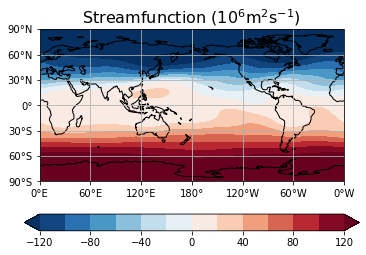

In [13]:
# Plot streamfunction.
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
clevs = [-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120]
sf_fill = ax1.contourf(lons_c, lats, sf_dec * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
ax1.coastlines()
ax1.gridlines()
ax1.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
plt.colorbar(sf_fill, orientation='horizontal')
plt.title('Streamfunction ($10^6$m$^2$s$^{-1}$)', fontsize=16)

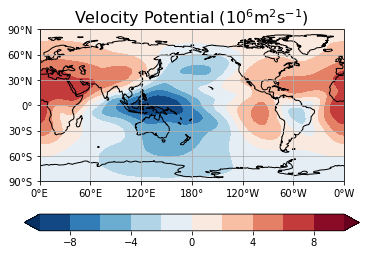

In [14]:
# Plot velocity potential.
plt.figure()
ax2 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
clevs = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
vp_fill = ax2.contourf(lons_c, lats, vp_dec * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
ax2.coastlines()
ax2.gridlines()
ax2.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
plt.colorbar(vp_fill, orientation='horizontal')
plt.title('Velocity Potential ($10^6$m$^2$s$^{-1}$)', fontsize=16)
plt.show()